In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import time

from smart_home import Load, SmartHome

import matplotlib 
% matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
path = 'Data'

In [3]:
consumption_factor = 2

##### FOR THE PREDICTION, CHOOSE A DATE IN AUGUST 2018!

# Load production and consumption data

In [4]:
weather_hourly = pd.read_csv(os.path.join(path, 'data_hourly.csv'))
weather_hourly['timestamps'] = pd.to_datetime(weather_hourly.timestamps)
weather_hourly.set_index('timestamps', inplace = True)

In [5]:
production_10min = pd.read_csv(os.path.join(path, 'PV_output.csv'), header = None)
production_10min.rename({0 : 'timestamps', 1 : 'power'}, axis = 1, inplace = True)
production_10min['timestamps'] = pd.to_datetime(production_10min.timestamps)
production_10min.set_index('timestamps', inplace = True)
production_10min = production_10min.power / 1000

In [6]:
consumption_10min = pd.read_csv(os.path.join(path, 'baseload_aug_10min.csv'), header = None, nrows = 31*24*6)
consumption_10min.rename({0 : 'timestamps', 1 : 'power'}, axis = 1, inplace = True)
consumption_10min['timestamps'] = pd.to_datetime(consumption_10min.timestamps, format = '%d/%m/%Y %H:%M')
consumption_10min.set_index('timestamps', inplace = True)
consumption_10min['power'] = consumption_10min.power * consumption_factor * 6

In [7]:
consumption_hourly = pd.read_csv(os.path.join(path, 'baseload_aug_hourly.csv'), header = None, nrows = 31*24)
consumption_hourly.rename({0 : 'timestamps', 1 : 'power'}, axis = 1, inplace = True)
consumption_hourly['timestamps'] = pd.to_datetime(consumption_hourly.timestamps, format = '%d/%m/%Y %H:%M')
consumption_hourly.set_index('timestamps', inplace = True)
consumption_hourly['power'] = consumption_hourly.power * consumption_factor

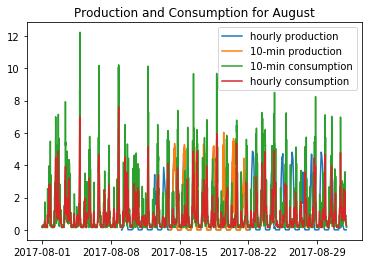

In [8]:
plt.figure()
plt.plot(weather_hourly.power_output_noisy['20170801':'20170831'], label = 'hourly production')
plt.plot(production_10min['20170801':'20170831'], label = '10-min production')
plt.plot(consumption_10min, label = '10-min consumption')
plt.plot(consumption_hourly, label = 'hourly consumption')
plt.title('Production and Consumption for August')
plt.legend()
plt.show()

# Initialize smart home

### Declare variable loads

In [9]:
cleaning_robot = Load(power = 0.4, duration = 3, name = 'cleaning_robot')
washing_machine = Load(power = 1.2, duration = 2, name = 'washing_machine')
variable_loads = (cleaning_robot, washing_machine)

### Declare smart home

/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


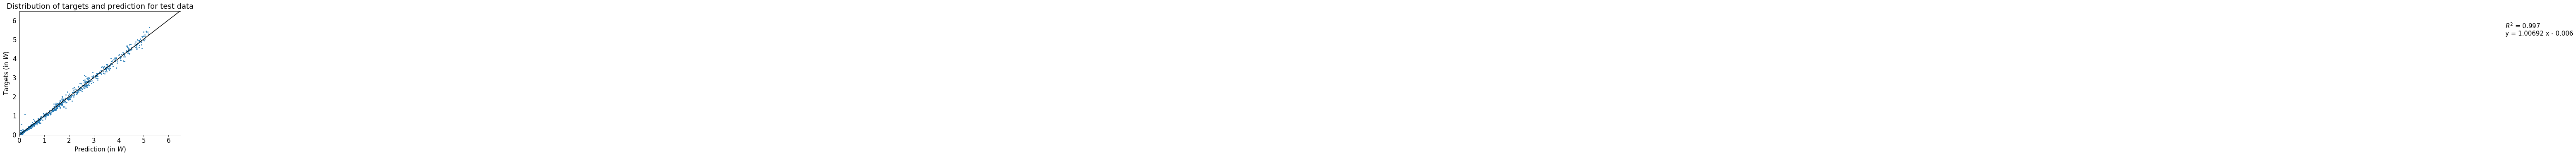

set up and trained weather predictor with data up to  20170731
set up battery with capacity 13.50 and maximum power 5.00
set up variable load optimizer
set up base load


In [10]:
my_home = SmartHome(battery_capacity = 13.5, battery_power = 5, 
                    variable_loads = variable_loads,
                    base_load = consumption_hourly,
                    weather_data = weather_hourly, train_date = '20170731',
                    log_name = os.path.join(path, 'log.csv')
                   )

In [11]:
predict_start = pd.to_datetime('20170814-00')
predict_end = pd.to_datetime('20170821-23')

In [12]:
curr_time = pd.to_datetime('20170814-20')

## Set up evaluation

In [13]:
# load historical token data:
token_historical = pd.read_csv(os.path.join(path, 'tokens.csv'), index_col = 0)

In [14]:
historic_data = pd.read_csv(os.path.join(path, 'log_history.csv'), index_col = 0)
historic_data.index = pd.to_datetime(historic_data.index)

### evaluate and plot data

In [22]:
def evaluate(output, curr_time):
    labels = np.append(pd.to_datetime(token_historical.index).day.values, curr_time.strftime('%d')) 

    fig, ax = plt.subplots(figsize = (9,5))
    plt.bar(range(len(token_historical)), token_historical.token_value)
    plt.bar(len(token_historical), output['token_value'])
    plt.xticks(range(len(token_historical)+1))
    ax.set_xticklabels(labels)
    plt.ylabel('Tokens (1 token = 1kWh)')
    plt.xlabel('Day (August 2017)')
    plt.title('Your token history for the last two weeks')
    # plt.show()

    timelabel = curr_time.strftime('%Y-%m-%d_%H')
    plt.savefig(os.path.join(path, ('%s_tokens.png' %timelabel)), dpi=300)
    plt.close()
    
    ######
    hist_time = curr_time - pd.Timedelta(days=1) + pd.Timedelta(hours=1)
    historic_production = production_10min[hist_time : curr_time]
    historic_consumption = consumption_10min[hist_time : curr_time]
    
    historic_consumption = historic_consumption.merge(historic_data.resample('600S').pad(), right_index = True, left_index = True)
    
    total_consumption_hist = historic_consumption.power + historic_consumption.var_consumption
    battery_consumption_hist = historic_consumption.battery_consumption + total_consumption_hist
    predicted_load = output['predicted_baseload'] + output['predicted_var_load']
    predicted_production = pd.Series(data = output['predicted_production'], index = output['predicted_baseload'].index)

    fig, ax = plt.subplots(figsize = (9,5))
    # plot historic data:
    historic_production.plot(label = 'production', c = 'orange')
    battery_consumption_hist.plot(label = 'battery loading', c = 'deepskyblue')
    total_consumption_hist.plot(label = 'consumption', c = 'g')

    # plot future data
    predicted_load.plot(label = 'predicted consumption' , c = 'g', LineStyle = '--')
    predicted_production.plot(label = 'predicted production', c = 'orange', LineStyle = '--')

    plt.ylabel('Energy (in kWh)')
    plt.xlabel('Hours')
    plt.title('Your past and future energy balance')
    plt.legend()
    plt.savefig(os.path.join(path, ('%s_energy.png' %timelabel)), dpi=300)
    plt.close()

# RUN SMART HOME IN REAL TIME

In [19]:
start_smart_home = '20170815-00'
end_smart_home = '20170815-23'

2017-08-15 00:00:00
resetted current token
current PV production: 0.00kWh
current base consumption: 0.12kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.29
current battery usage: 0.00kWh
total self consumption: 0.00kWh
new token value for today: 0.00
predicted all future loads


2017-08-15 01:00:00
current PV production: 0.00kWh
current base consumption: 0.12kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.28
current battery usage: 0.00kWh
total self consumption: 0.00kWh
new token value for today: 0.01
predicted all future loads


2017-08-15 02:00:00
current PV production: 0.00kWh
current base consumption: 0.22kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.27
current battery usage: 0.00kWh
total self consumption: 0.00kWh
new token value for today: 0.01
predicted all future loads


2017-08-15 03:00:00
current PV production: 0.00kWh
current base consumptio

/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 11:00:00
current PV production: 5.03kWh
current base consumption: 0.22kWh
current variable consumption: 0.00kWh
charge battery; new battery state of charge: 1.00
current battery usage: 2.40kWh
total self consumption: 2.62kWh
new token value for today: 17.83
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 12:00:00
current PV production: 4.82kWh
current base consumption: 1.22kWh
current variable consumption: 0.00kWh
current battery usage: 0.00kWh
total self consumption: 1.22kWh
new token value for today: 19.06
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 13:00:00
current PV production: 4.36kWh
current base consumption: 0.29kWh
current variable consumption: 0.00kWh
current battery usage: 0.00kWh
total self consumption: 0.29kWh
new token value for today: 19.35
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 14:00:00
current PV production: 2.70kWh
current base consumption: 0.45kWh
current variable consumption: 0.00kWh
current battery usage: 0.00kWh
total self consumption: 0.45kWh
new token value for today: 19.80


/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


predicted all future loads


2017-08-15 15:00:00
current PV production: 1.33kWh
current base consumption: 0.16kWh
current variable consumption: 0.00kWh
current battery usage: 0.00kWh
total self consumption: 0.16kWh
new token value for today: 19.95
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 16:00:00
current PV production: 0.29kWh
current base consumption: 0.08kWh
current variable consumption: 0.00kWh
current battery usage: 0.00kWh
total self consumption: 0.08kWh
new token value for today: 20.03
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 17:00:00
current PV production: 0.27kWh
current base consumption: 1.02kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.94
current battery usage: 0.00kWh
total self consumption: 0.27kWh
new token value for today: 20.30
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 18:00:00
current PV production: 0.05kWh
current base consumption: 1.19kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.86
current battery usage: 0.00kWh
total self consumption: 0.05kWh
new token value for today: 20.35
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 19:00:00
current PV production: 0.00kWh
current base consumption: 2.99kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.64
current battery usage: 0.00kWh
total self consumption: 0.00kWh
new token value for today: 20.35
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 20:00:00
current PV production: 0.00kWh
current base consumption: 0.60kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.59
current battery usage: 0.00kWh
total self consumption: 0.00kWh
new token value for today: 20.36
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 21:00:00
current PV production: 0.01kWh
current base consumption: 0.95kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.52
current battery usage: 0.00kWh
total self consumption: 0.01kWh
new token value for today: 20.36
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 22:00:00
current PV production: 0.00kWh
current base consumption: 0.65kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.48
current battery usage: 0.00kWh
total self consumption: 0.00kWh
new token value for today: 20.37
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-08-15 23:00:00
current PV production: 0.01kWh
current base consumption: 0.49kWh
current variable consumption: 0.00kWh
discharged battery; new battery state of charge: 0.44
current battery usage: 0.00kWh
total self consumption: 0.01kWh
new token value for today: 20.37
predicted all future loads




/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


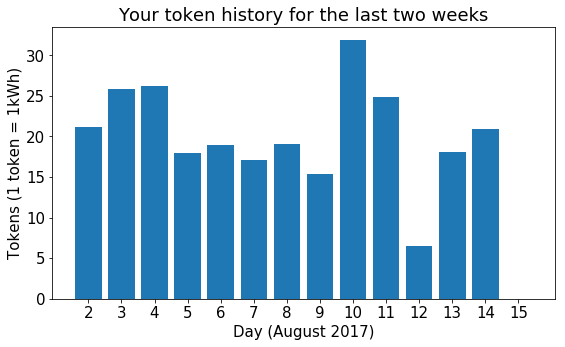

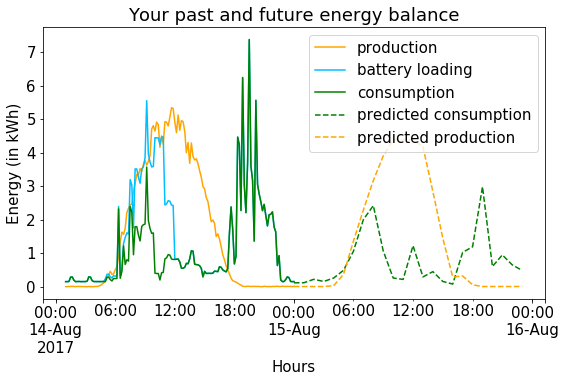

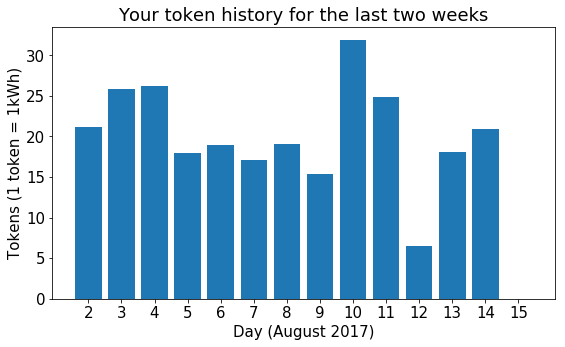

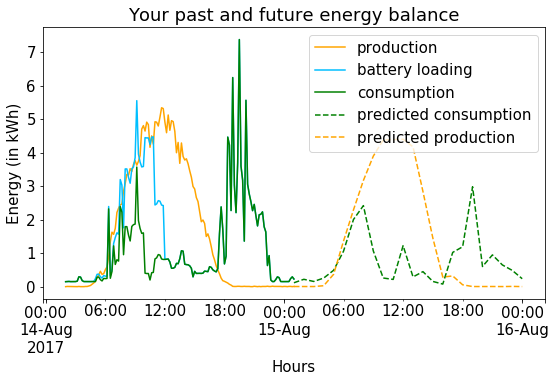

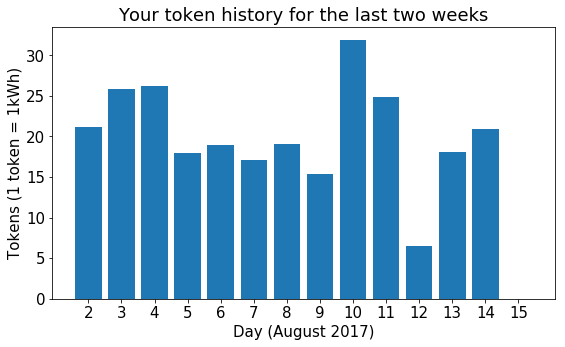

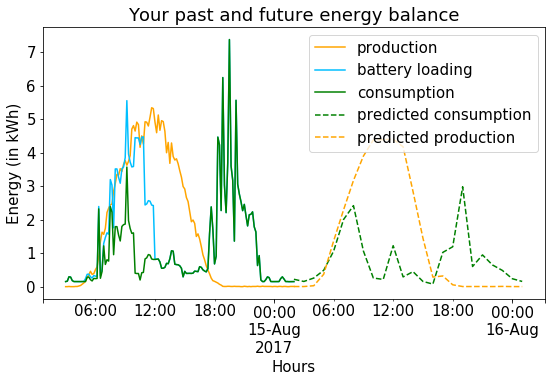

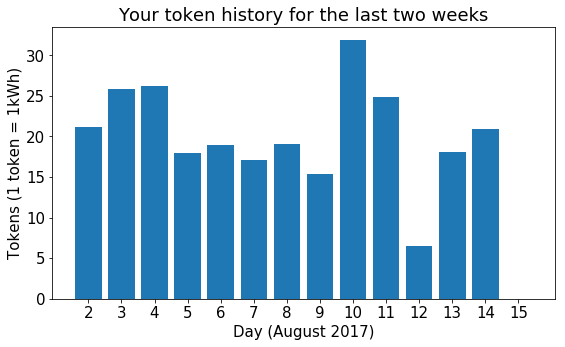

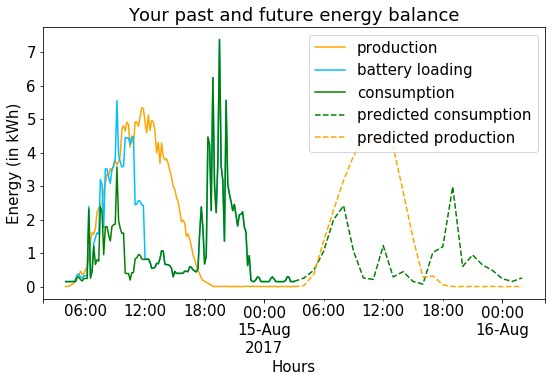

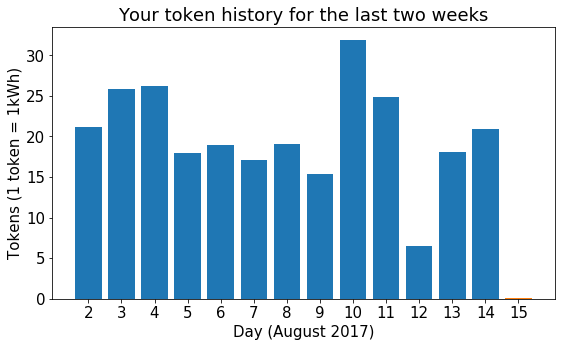

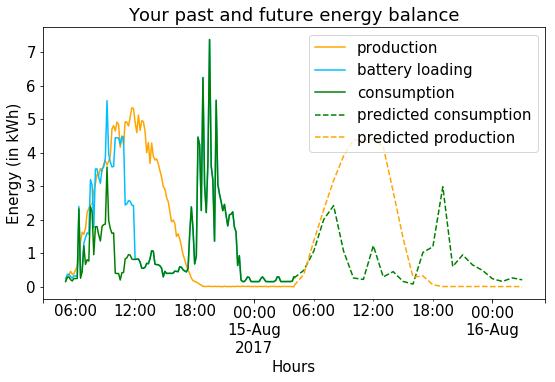

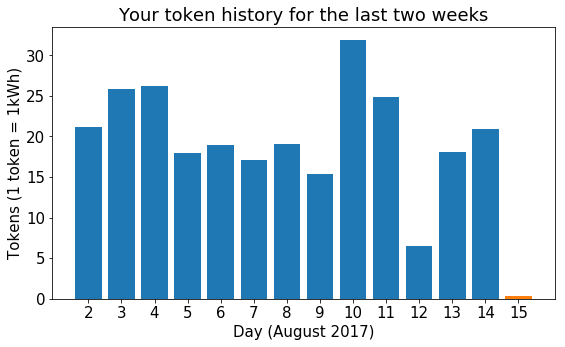

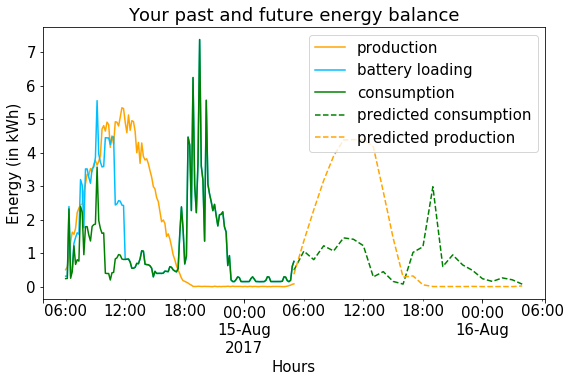

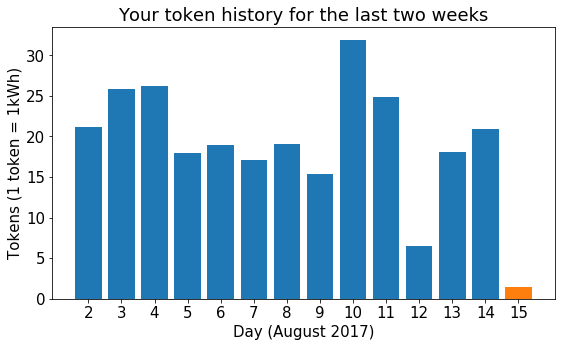

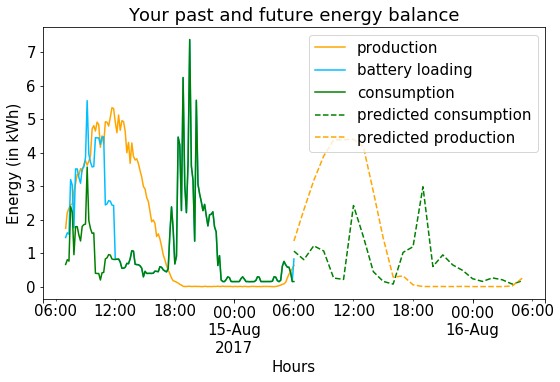

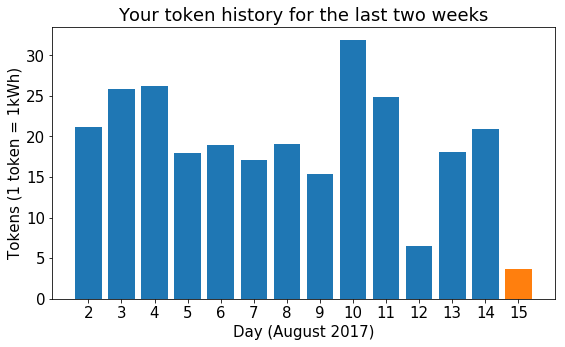

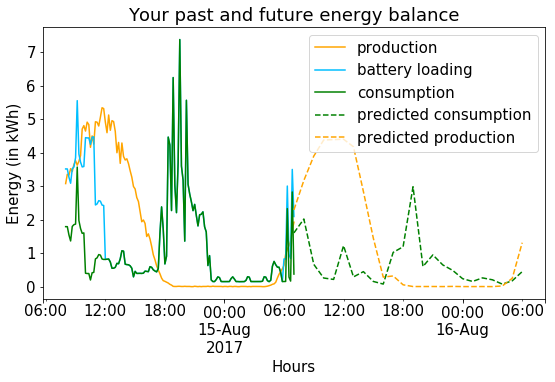

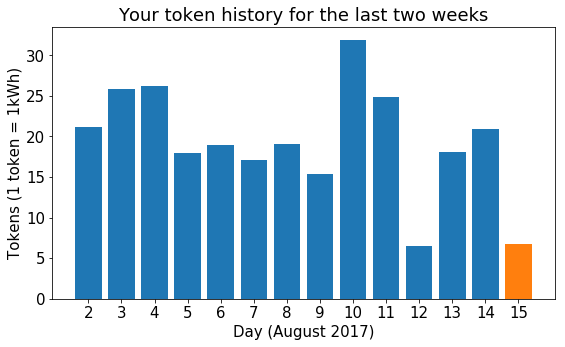

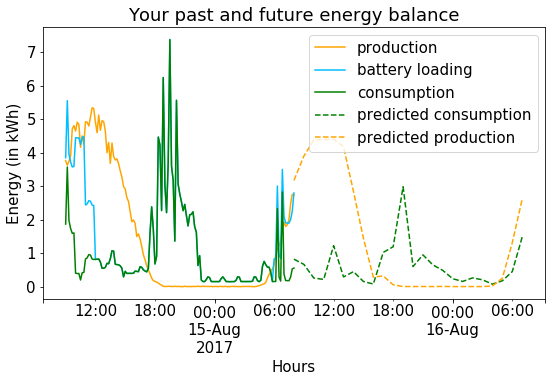

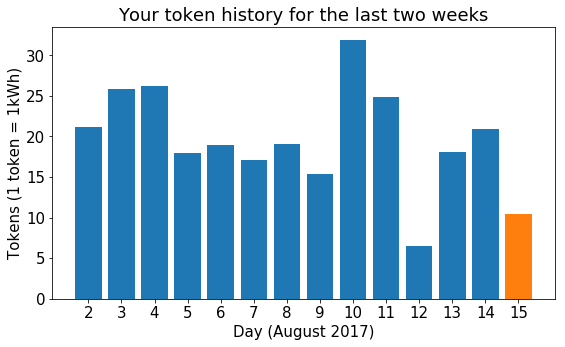

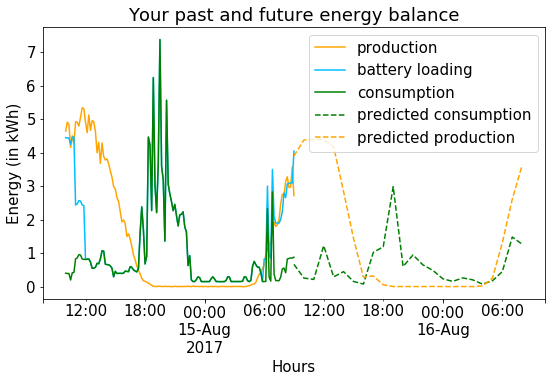

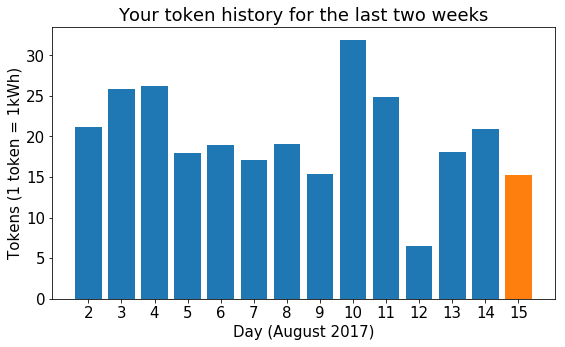

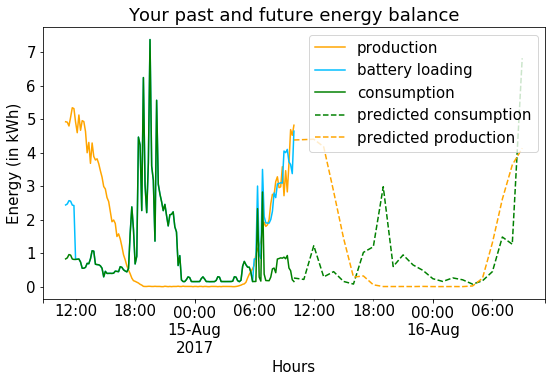

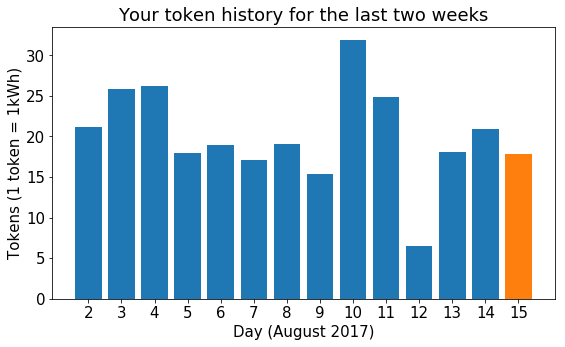

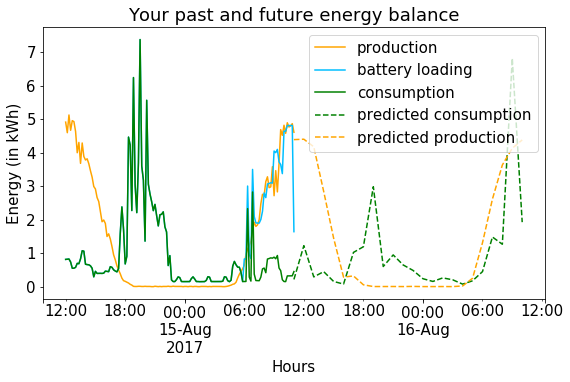

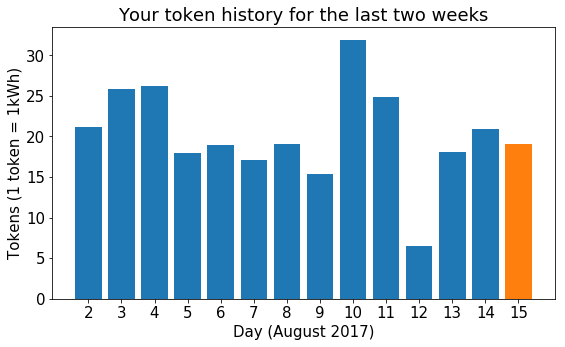

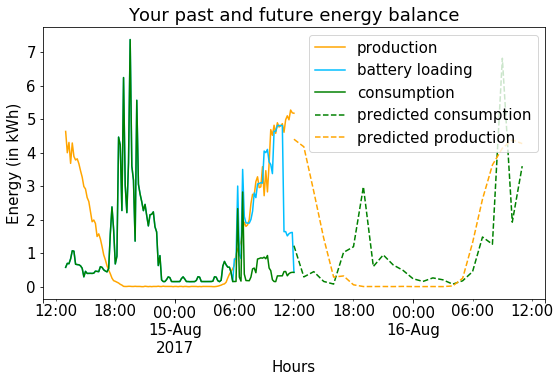

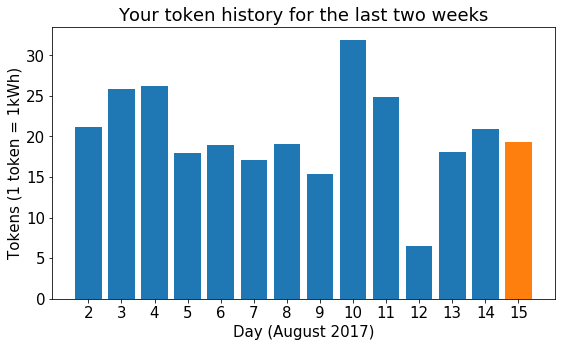

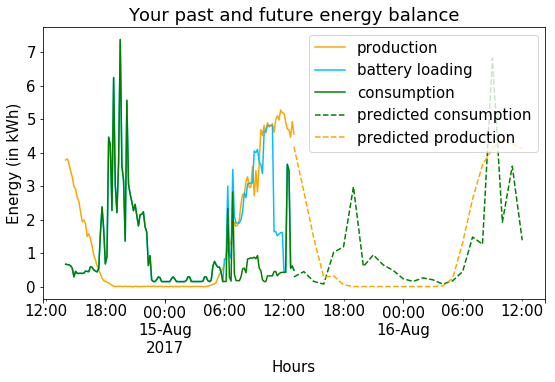

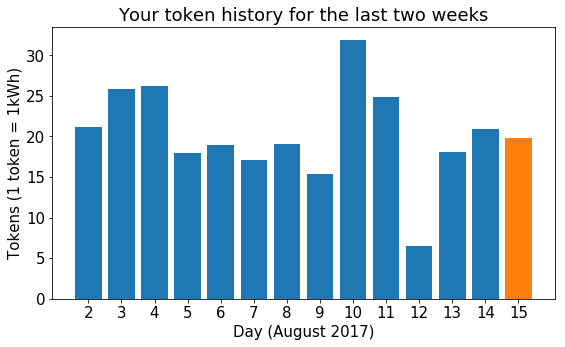

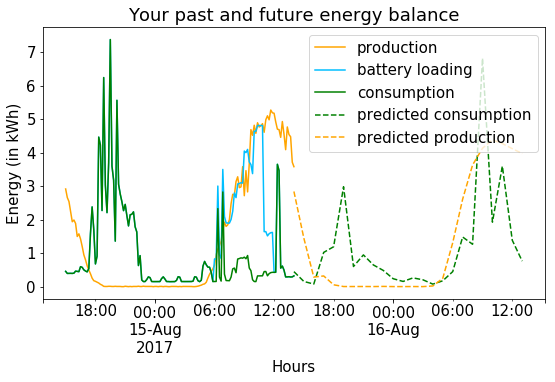

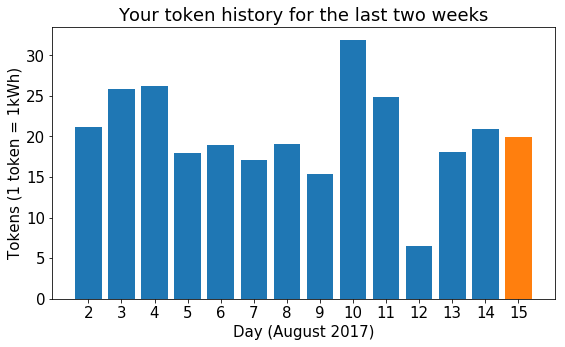

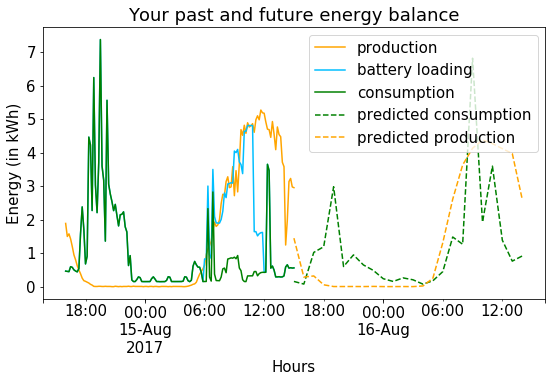

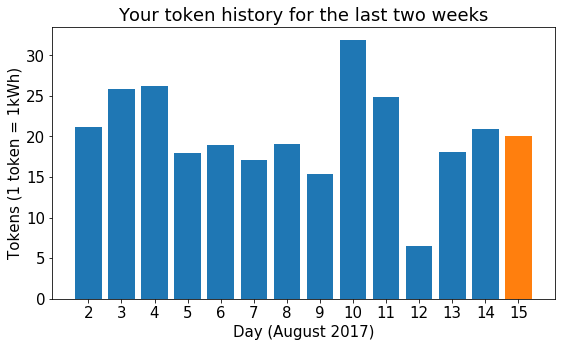

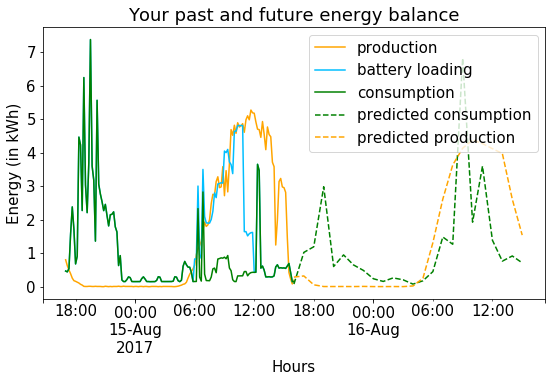

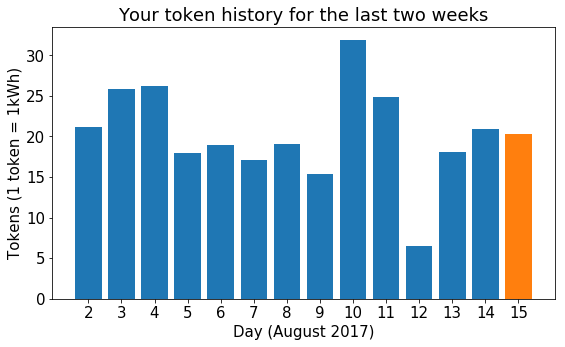

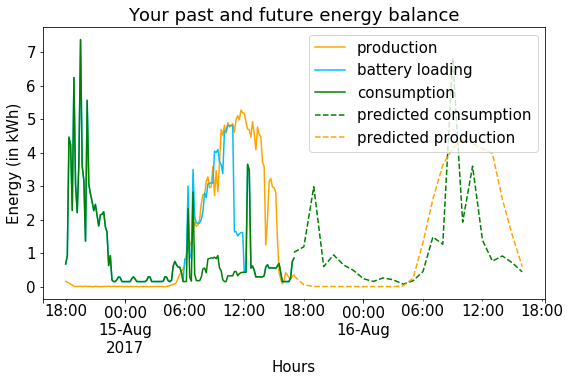

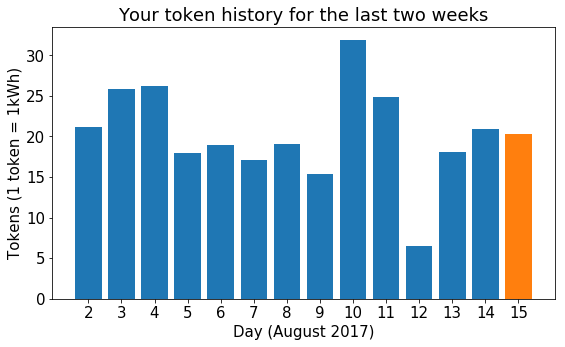

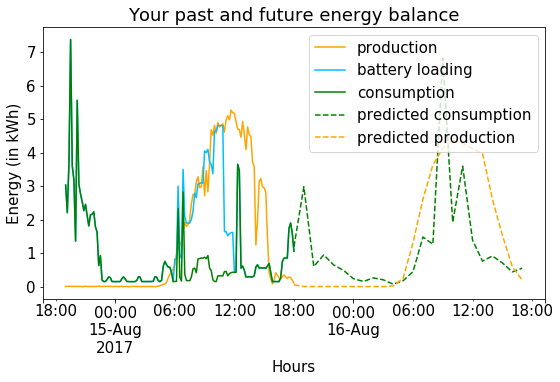

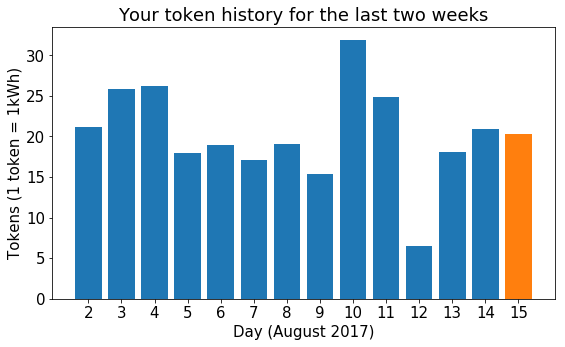

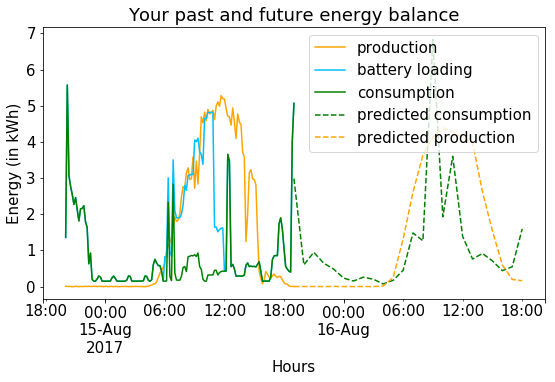

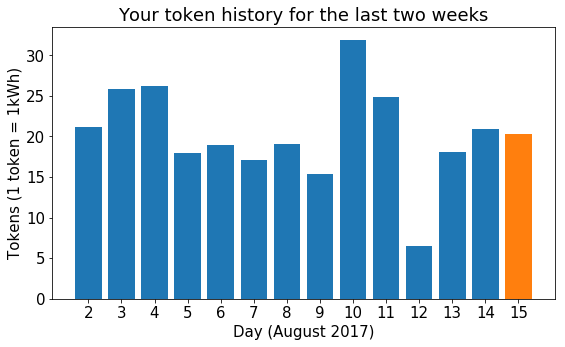

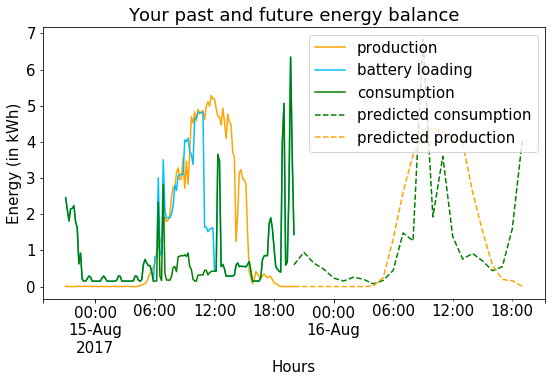

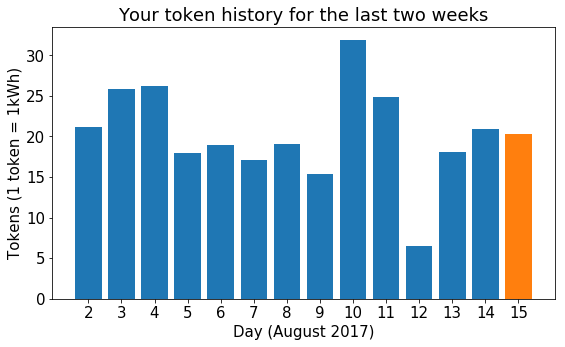

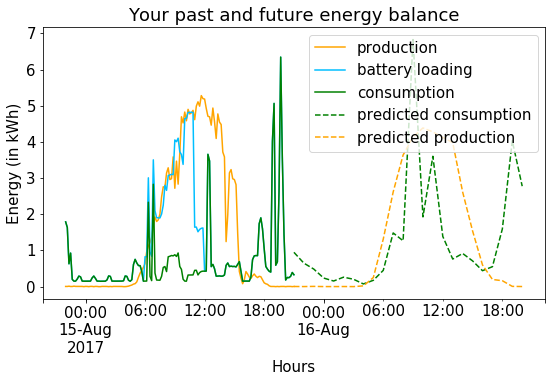

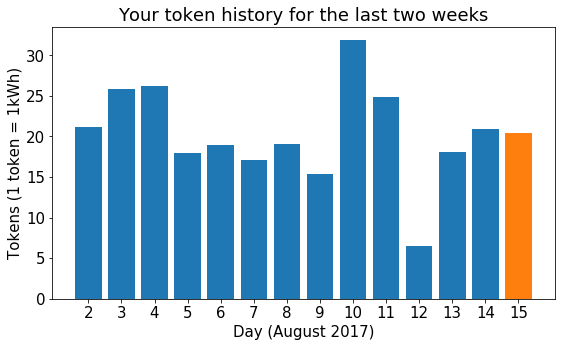

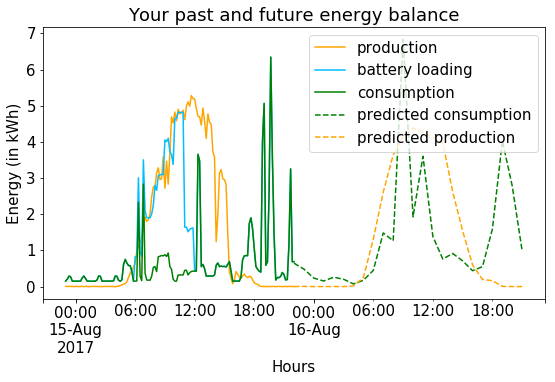

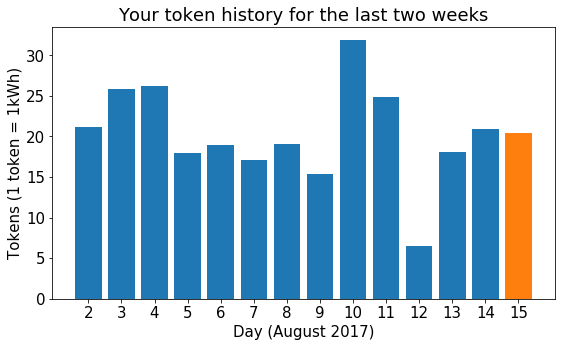

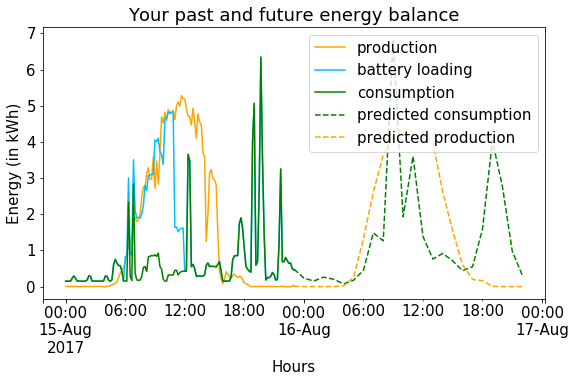

In [20]:
for curr_time in pd.date_range(start_smart_home, end_smart_home, freq = 'h'):
    print(curr_time)
    output = my_home.update(curr_time)
    print('\n')
    time.sleep(0.1)
    
    evaluate(output, curr_time)

# Evaluation

## Evaluate past data to get historical token data (once only)

log_hist = pd.read_csv(os.path.join(path, 'log_history_2weeks.csv'))
log_hist['timestamp'] = pd.to_datetime(log_hist.timestamp, format = '%d/%m/%Y %H:%M')
log_hist.set_index('timestamp', inplace = True)
daily_frame = log_hist.groupby(log_hist.index.date).sum()
token_frame = daily_frame.drop(['PV_production', 'base_consumption', 'var_consumption', 'battery_consumption'], axis = 1)
token_frame.rename({'self_consumption' : 'token_value'}, inplace = True, axis = 1)
token_frame.to_csv(os.path.join(path, 'tokens.csv'))

## Spielwiese

### note: give tokens for USING energy (also from battery)